In [1]:
#!/usr/bin/env python
# coding: utf-8


import tensorflow as tf
print(tf.__version__) # 1.14.0 ---> 2.1.0

   
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())    
    
    
import os
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras

2.5.0-dev20201212
1 Physical GPUs, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14077996796597697983
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 20039100748
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7397840345794721865
physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6"
]


In [2]:
data_path = './'
# dirs = ['defect_aug_1','fair_aug_1', 'nclabel_aug_1', 'nlabel_aug_1']
dirs = ['defect_aug','fair_aug']

In [3]:
import pathlib
data_path = './'
data_dir = data_path + "train_image/"
print(data_dir)
data_dir = pathlib.Path(data_dir)
print(data_dir)

./train_image/
train_image


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10200


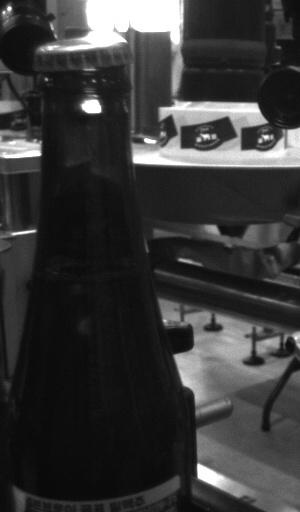

In [5]:
import PIL
defect = list(data_dir.glob('X/*'))
PIL.Image.open(str(defect[0]))

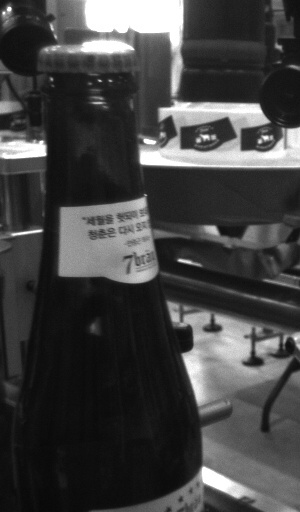

In [6]:
import PIL
fair = list(data_dir.glob('o/*'))
PIL.Image.open(str(fair[0]))

In [7]:
batch_size = 32
img_height = 512
img_width = 300

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',  
  batch_size=batch_size)

Found 10200 files belonging to 2 classes.
Using 8160 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

Found 10200 files belonging to 2 classes.
Using 2040 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['O', 'X']


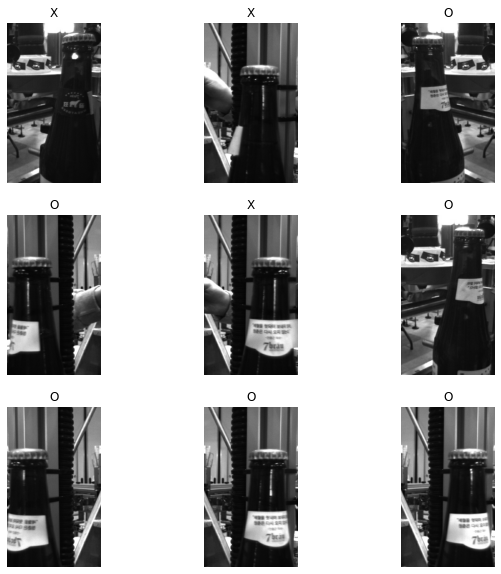

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 300, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
num_classes = 2

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), (1, 1), 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=0.3),

    layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=0.3),

    layers.Conv2D(128, (3, 3), (1, 1), 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=0.3),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 150, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 75, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 75, 64)       0

In [19]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
255/255 [==============================] - 28s 92ms/step - loss: 2.2042 - accuracy: 0.7163 - val_loss: 0.1293 - val_accuracy: 0.9652
Epoch 2/5
255/255 [==============================] - 19s 75ms/step - loss: 0.0890 - accuracy: 0.9687 - val_loss: 0.0265 - val_accuracy: 0.9956
Epoch 3/5
255/255 [==============================] - 19s 74ms/step - loss: 0.0427 - accuracy: 0.9840 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 4/5
255/255 [==============================] - 19s 75ms/step - loss: 0.0220 - accuracy: 0.9914 - val_loss: 0.0060 - val_accuracy: 0.9985
Epoch 5/5
255/255 [==============================] - 19s 74ms/step - loss: 0.0173 - accuracy: 0.9927 - val_loss: 0.0091 - val_accuracy: 0.9961


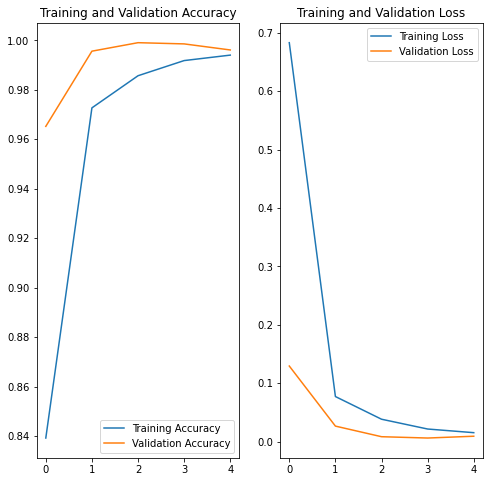

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model.save(data_path+'dataset.h5')

In [22]:
test_data_dir = data_path + "test_image/"
test_data_dir = pathlib.Path(test_data_dir)
test_image_count = len(list(test_data_dir.glob('*')))
print(test_image_count)

2


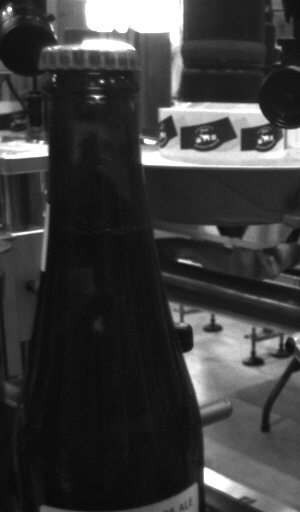

In [23]:
test_defect = list(test_data_dir.glob('test_defect/*'))
PIL.Image.open(str(test_defect[1]))

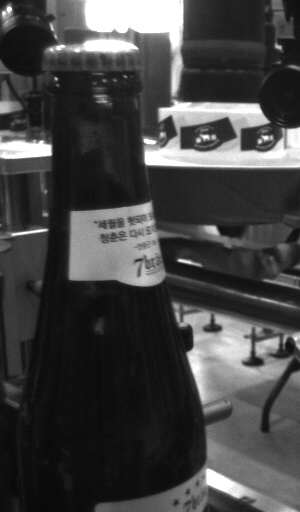

In [24]:
test_fair = list(test_data_dir.glob('test_fair/*'))
PIL.Image.open(str(test_fair[1]))

In [31]:
for i in range (len(test_fair)):
    img = keras.preprocessing.image.load_img(
        test_defect[i], target_size=(img_height, img_width), color_mode='rgb'
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to defect {:} {} with a {:.2f} percent confidence."
        .format(i, class_names[np.argmax(score)], 100 * np.max(score))
    )

This image most likely belongs to defect 0 O with a 100.00 percent confidence.
This image most likely belongs to defect 1 O with a 100.00 percent confidence.
This image most likely belongs to defect 2 X with a 100.00 percent confidence.
This image most likely belongs to defect 3 X with a 100.00 percent confidence.
This image most likely belongs to defect 4 X with a 97.14 percent confidence.
This image most likely belongs to defect 5 X with a 74.85 percent confidence.
This image most likely belongs to defect 6 X with a 98.39 percent confidence.
This image most likely belongs to defect 7 X with a 95.23 percent confidence.
This image most likely belongs to defect 8 X with a 100.00 percent confidence.
This image most likely belongs to defect 9 X with a 99.72 percent confidence.
This image most likely belongs to defect 10 X with a 100.00 percent confidence.
This image most likely belongs to defect 11 X with a 98.53 percent confidence.
This image most likely belongs to defect 12 X with a 100

In [32]:
for i in range (len(test_defect)):
    img = keras.preprocessing.image.load_img(
        test_fair[i], target_size=(img_height, img_width), color_mode='rgb'
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to fair {:} {} with a {:.2f} percent confidence."
        .format(i, class_names[np.argmax(score)], 100 * np.max(score))
    )

This image most likely belongs to fair 0 O with a 100.00 percent confidence.
This image most likely belongs to fair 1 O with a 100.00 percent confidence.
This image most likely belongs to fair 2 O with a 100.00 percent confidence.
This image most likely belongs to fair 3 O with a 100.00 percent confidence.
This image most likely belongs to fair 4 O with a 100.00 percent confidence.
This image most likely belongs to fair 5 O with a 100.00 percent confidence.
This image most likely belongs to fair 6 O with a 99.08 percent confidence.
This image most likely belongs to fair 7 O with a 100.00 percent confidence.
This image most likely belongs to fair 8 O with a 100.00 percent confidence.
This image most likely belongs to fair 9 O with a 99.95 percent confidence.
This image most likely belongs to fair 10 O with a 100.00 percent confidence.
This image most likely belongs to fair 11 O with a 100.00 percent confidence.
This image most likely belongs to fair 12 O with a 91.60 percent confidence.